# Downsample_stacks_and_usage

In [6]:
import os
import numpy as np
import random

import matplotlib.pyplot as plt


import imageio

from skimage import io, transform
from skimage.util import img_as_float32


In [10]:
'''
This should ventually go into a config
'''

ROOT = 'Z://Collaboration_data/Iordonova_lab/'
experiment_folder = 'Iordanova_Control-M-R8_NeuN-cFOS/'
cFOS_folder = 'Iordanova_Control-M-R8_cFOS/'
neun_folder = 'Iordanova_Control-M-R8_NeuN/'

file_list = os.listdir(ROOT+experiment_folder+cFOS_folder)
# file_list

In [11]:
DS_FACTOR = 5 # Downsampling factor

In [12]:
#Keep data generated separate from the data provided:

def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")
    else:
        print(f"Folder already exists: {folder_path}")

# Example usage
output_dir = ROOT + 'my_generated/'
create_folder_if_not_exists(output_dir)  

experiment_output = output_dir + experiment_folder
create_folder_if_not_exists(experiment_output)  

Folder already exists: Z://Collaboration_data/Iordonova_lab/my_generated/
Folder already exists: Z://Collaboration_data/Iordonova_lab/my_generated/Iordanova_Control-M-R8_NeuN-cFOS/


# Functions from other notebook:

In [13]:
def load(img_identifier):
    
    fos_path = ROOT+experiment_folder+cFOS_folder +img_identifier#+'.tif'
    neun_path =  ROOT+experiment_folder+neun_folder +img_identifier#+'.tif'
   
    fos_img = io.imread(fos_path).astype(np.int32) 
    neun_img = io.imread(neun_path).astype(np.int32) 
#     neun_img = np.empty(fos_img.shape)
    
    print('loaded: ', img_identifier, ' from: ',fos_path)
    print('min, max: ', np.min(fos_img), np.max(fos_img))
    
    return neun_img, fos_img



In [14]:
'''Load this instead from the Python module'''

import skimage.filters
import skimage.measure
from skimage.measure import regionprops_table

def segment_image(image, x_offset, y_offset,method='otsu', custom_threshold=None):
    if method == 'otsu':
        threshold = skimage.filters.threshold_otsu(image)
    elif method == 'mean':
        threshold = np.mean(image)
    elif method == 'custom':
        if custom_threshold is not None:
            threshold = custom_threshold
        else:
            raise ValueError("Please provide a custom threshold value.")
    else:
        raise ValueError("Invalid method specified. Choose either 'otsu', 'mean', or 'custom'.")

    segmented_image = image > threshold
    labeled_image = skimage.measure.label(segmented_image)
    properties = regionprops_table(labeled_image, properties=('centroid',))

    positions = np.column_stack(np.where(labeled_image > 0)) + np.array([x_offset, y_offset])

    return segmented_image, positions


In [15]:

# ROOT = "path/to/root/"
# experiment_folder = "path/to/experiment/folder/"
# cFOS_folder = "path/to/cfos/folder/"
# neun_folder = "path/to/neun/folder/"

# def load_images(img_identifiers):
#     images = []

#     for img_identifier in img_identifiers:
#         fos_path = ROOT + experiment_folder + cFOS_folder + img_identifier
#         neun_path = ROOT + experiment_folder + neun_folder + img_identifier

#         fos_img = img_as_float32(io.imread(fos_path))
#         neun_img = np.empty(fos_img.shape, dtype=np.float32)

#         images.append((neun_img, fos_img))

#     return np.array(images)

Preprocessing Functions

In [16]:
def downsample_image(image, downsample_factor=4):
    downsampled_shape = tuple(s // downsample_factor for s in image.shape)
    return transform.resize(image, downsampled_shape, order=3, anti_aliasing=True)

def upscale_slice(image_slice, original_shape):
    return transform.resize(image_slice, original_shape, order=3, anti_aliasing=True)



In [ ]:
def save_downsampled_png(img_ds, filepath):
    
    # Normalize the intensity values to the range [0, 255]
    normalized_img = (img_ds - img_ds.min()) / (img_ds.max() - img_ds.min())
    scaled_img = (normalized_img * 255).astype(np.uint8)

    # Save the image as a 24-bit PNG
    imageio.imwrite(filepath+'.png', scaled_img)

In [8]:
def downsample_folder(file_list):
    for identifier in file_list:
        if identifier.endswith('.tif'):
            print(identifier)
            neun_img, cfos_img = load(identifier)

            assert neun_img.shape == cfos_img.shape
            IMG_DIM = neun_img.shape # Temp, to config. Then this assert will make sense. 
            assert neun_img.shape == IMG_DIM
            assert cfos_img.shape == IMG_DIM

            neun_img_ds, cfos_img_ds =  downsample_image(neun_img, downsample_factor=DS_FACTOR),  downsample_image(cfos_img, downsample_factor=DS_FACTOR)

            save_downsampled_png(neun_img_ds, neun_output + identifier[:-4])
            save_downsampled_png(cfos_img_ds, cfos_output + identifier[:-4])

        
    
    
    

In [ ]:
'''get_volume_from_folder'''


def get_volume_from_folder(folder):

    '''Load a specified folder as an image volume. '''

    # Move the depth axis to the last position
    reordered_stack = np.moveaxis(neur_ds_stack, 0, -1)

    print(reordered_stack.shape)  # Output: (4718, 2750, 100)

Usage of functions and building a pipeline

In [ ]:
# Downsample images
downsampled_images = [(downsample_image(neun_img), downsample_image(fos_img)) for neun_img, fos_img in original_images]

# Access a specific downsampled image
downsampled_neun_img, downsampled_fos_img = downsampled_images[1]

# Upscale the downsampled image back to its original dimensions
original_shape = (18873, 11002)
upscaled_neun_img = upscale_slice(downsampled_neun_img, original_shape)
upscaled_fos_img = upscale_slice(downsampled_fos_img, original_shape)

In [105]:

neun_output = output_dir + experiment_folder + 'neun_ds/'
create_folder_if_not_exists(neun_output)  

cfos_output = output_dir + experiment_folder + 'cfos_ds/'
create_folder_if_not_exists(cfos_output)  

Folder already exists: Z://Collaboration_data/Iordonova_lab/my_generated/Iordanova_Control-M-R8_NeuN-cFOS/neun_ds/
Folder already exists: Z://Collaboration_data/Iordonova_lab/my_generated/Iordanova_Control-M-R8_NeuN-cFOS/cfos_ds/


In [41]:
neur_ds_stack = np.asarray(neur_ds_list) 
cfos_ds_stack = np.asarray(cfos_ds_list) 
    
np.save(experiment_output+'neur_ds',neur_ds_stack)
np.save(experiment_output+'cfos_ds',cfos_ds_stack)

# Affine transforms

In [61]:
# Load the preprocessed (downsampled) data
# neur_ds_stack_ = np.load(experiment_output+'neur_ds.npy')
cfos_ds_stack_ = np.load(experiment_output+'cfos_ds.npy')

cfos_ds_stack_.shape

(4718, 2750, 100)

In [62]:
from scipy.ndimage import affine_transform

In [63]:
def generate_affine_matrix(scale=(1, 1, 1), rotation=(0, 0, 0), translation=(0, 0, 0)):

    '''Generate an affine matrix from the user-defined paramters'''

    s_x, s_y, s_z = scale
    r_x, r_y, r_z = np.deg2rad(rotation)  # Convert degrees to radians
    t_x, t_y, t_z = translation

    # Scale matrix
    scale_matrix = np.array([
        [s_x, 0, 0, 0],
        [0, s_y, 0, 0],
        [0, 0, s_z, 0],
        [0, 0, 0, 1]
    ])

    # Rotation matrices
    rot_x_matrix = np.array([
        [1, 0, 0, 0],
        [0, np.cos(r_x), -np.sin(r_x), 0],
        [0, np.sin(r_x), np.cos(r_x), 0],
        [0, 0, 0, 1]
    ])

    rot_y_matrix = np.array([
        [np.cos(r_y), 0, np.sin(r_y), 0],
        [0, 1, 0, 0],
        [-np.sin(r_y), 0, np.cos(r_y), 0],
        [0, 0, 0, 1]
    ])

    rot_z_matrix = np.array([
        [np.cos(r_z), -np.sin(r_z), 0, 0],
        [np.sin(r_z), np.cos(r_z), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    # Translation matrix
    translation_matrix = np.array([
        [1, 0, 0, t_x],
        [0, 1, 0, t_y],
        [0, 0, 1, t_z],
        [0, 0, 0, 1]
    ])

    # Combine transformations
    affine_matrix = translation_matrix @ rot_z_matrix @ rot_y_matrix @ rot_x_matrix @ scale_matrix

    return affine_matrix

In [64]:
def transform_volume(volume, affine_matrix):
    '''Tranform a volume using the affine matrix'''

    transformed_volume = affine_transform(volume, affine_matrix[:3, :3], affine_matrix[:3, 3], order=1)
    return transformed_volume

In [65]:
def compare_sections(original_volume, transformed_volume, section_index):
    
    '''Visally compare specific section between the original and tranformed volumes'''
    
    original_slice = original_volume[:, :, section_index]
    transformed_slice = transformed_volume[:, :, section_index]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(original_slice, cmap='gray')
    ax1.set_title(f"Original Volume - Section {section_index}")
    ax1.axis('off')

    ax2.imshow(transformed_slice, cmap='gray')
    ax2.set_title(f"Transformed Volume - Section {section_index}")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()



In [9]:
volume = cfos_ds_stack_

arb_affine = generate_affine_matrix(scale=(1, 1, 1), rotation=(0,0, 0), translation=(0, 0, 10))

transformed_volume = transform_volume(volume, arb_affine)

NameError: name 'cfos_ds_stack_' is not defined

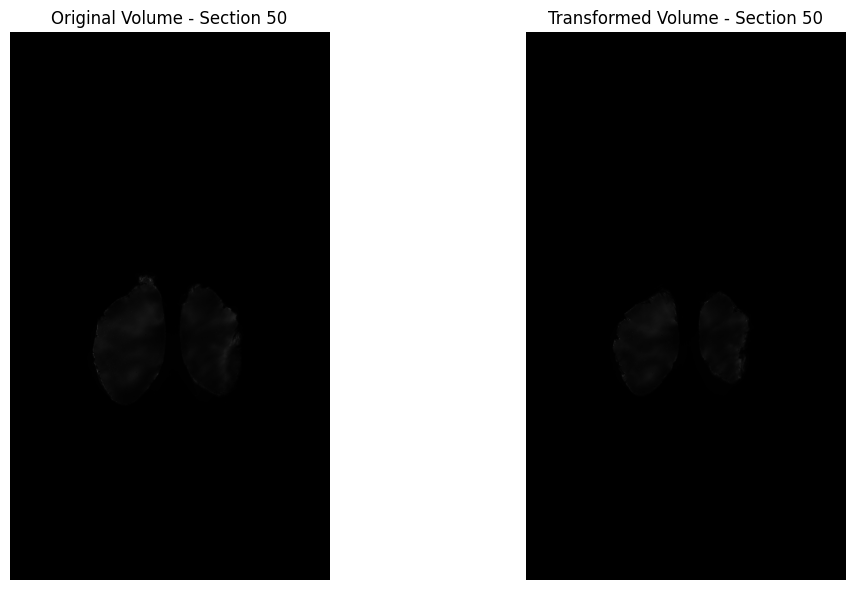

In [83]:

# Example usage
section_index = int(volume.shape[2] / 2) # Choose the section index you want to visualize
compare_sections(volume, transformed_volume, section_index)


In [ ]:
# # Example usage
# volume = np.random.rand(4718, 2750, 10)  # Replace this with your actual volume
# affine_matrix = generate_affine_matrix(scale=(1, 1, 1), rotation=(0, 0, 0), translation=(0, 0, 0))
# transformed_volume = transform_volume(volume, affine_matrix)

##### To be able to apply the transform generated on the downsampled image to the full sized images, extra steps need to be taken to adjust the scaling accordingly. 

Determine the downsampling factors for each axis (x, y, and z). For example, if the original image has dimensions (X, Y, Z), and the downsampled image has dimensions (X_ds, Y_ds, Z_ds), the downsampling factors are (X/X_ds, Y/Y_ds, Z/Z_ds).

Obtain the affine transformation matrix using the downsampled images.

Adjust the transformation matrix for the full-sized images by scaling the translation and scaling components with the downsampling factors.

In [ ]:
def adjust_affine_matrix_for_fullsize(affine_matrix, downsampling_factors):
    adjusted_matrix = affine_matrix.copy()
    ds_x, ds_y, ds_z = downsampling_factors

    # Adjust translation
    adjusted_matrix[:3, 3] *= [ds_x, ds_y, ds_z]

    # Adjust scaling
    adjusted_matrix[:3, :3] *= np.diag([ds_x, ds_y, ds_z])

    return adjusted_matrix

# Example usage
downsampling_factors = (X/X_ds, Y/Y_ds, Z/Z_ds)
fullsize_affine_matrix = adjust_affine_matrix_for_fullsize(affine_matrix, downsampling_factors)


##### We also need to be abe to apply the transformation to an individual slice from the volume

When you apply the affine transformation to a 2D slice, you need to adjust the translation component of the transformation matrix to account for the position of the slice along the z-axis. Here's a function that does this:




In [ ]:
def apply_affine_transform_to_slice(slice_img, affine_matrix, z_position):
    # Create a new affine matrix for the 2D slice
    slice_affine_matrix = affine_matrix.copy()

    # Adjust the translation component for the z_position
    slice_affine_matrix[:3, 3] += slice_affine_matrix[:3, 2] * z_position

    # Apply the affine transformation to the 2D slice
    transformed_slice = skimage.transform.warp(slice_img, np.linalg.inv(slice_affine_matrix[:2, :3]), preserve_range=True)

    return transformed_slice


##### We also want to be able o apply the affine transformation to a point cloud, such as that gvenertated by extracting the cell positions from the full-sized images.

You can apply the affine transformation matrix to a point cloud by performing matrix multiplication. To do this, you need to represent the point cloud's (x, y, z) coordinates as homogeneous coordinates by adding an extra dimension with a value of 1. Then, you can multiply the affine transformation matrix with the homogeneous coordinates to transform the point cloud into the new model space.

In [ ]:
def apply_affine_transform_to_point_cloud(point_cloud, affine_matrix):
    # Convert point cloud to homogeneous coordinates
    homogeneous_coords = np.hstack([point_cloud, np.ones((point_cloud.shape[0], 1))])

    # Apply the affine transformation
    transformed_point_cloud = np.matmul(affine_matrix, homogeneous_coords.T).T

    # Remove the homogeneous coordinate and return the transformed point cloud
    return transformed_point_cloud[:, :3]

# Example usage
point_cloud = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])  # Example point cloud
transformed_point_cloud = apply_affine_transform_to_point_cloud(point_cloud, fullsize_affine_matrix)


In [ ]:
# Save the point cloud of cell positions to be used in Blender, 

sample_points = np.load(output_dir+'sample.npy') # For now use this example point cloud. Eventually repoklace with one per experiment. (Or two???)
print(np.max(sample_points[:,0]),np.max(sample_points[:,1]),np.max(sample_points[:,2]))

# Ensure that the positions of the points are within the range to be expected based on the image dimensions. This should ensure there's not a swapped dimension somewhere. 
assert np.max(sample_points[:,0]) <= volume.shape[0] * DS_FACTOR
assert np.max(sample_points[:,1]) <= volume.shape[1] * DS_FACTOR
assert np.max(sample_points[:,2]) <= volume.shape[2] * DS_FACTOR

# sample_points = np.load(experiment_output+'sample.npy') # Eventually use this one, a point cloud per experiemnt


### Try loading the transformation info from the Quicknii xml/ json files and make sense of it in our workflow.



In [107]:
'''Added to quicnii_anchoring.py'''

import xml.etree.ElementTree as ET
import pandas as pd

def parse_xml_file(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    series_name = root.get('name')
    target = root.get('target')
    target_resolution = root.get('target-resolution')

    slices = []
    for slice_elem in root.iter('slice'):
        slice_info = {
            'filename': slice_elem.get('filename'),
            'nr': int(slice_elem.get('nr')),
            'width': int(slice_elem.get('width')),
            'height': int(slice_elem.get('height')),
            'anchoring': slice_elem.get('anchoring')
        }
        slices.append(slice_info)

    df_slices = pd.DataFrame(slices)
    return df_slices

def extract_anchoring_data(df_slices):
    anchoring_data = []
    for index, row in df_slices.iterrows():
        if pd.notnull(row['anchoring']):
            params = row['anchoring'].split('&')
            param_dict = {}
            for param in params:
                key, value = param.split('=')
                param_dict[key] = float(value)
            anchoring_data.append({
                'original_index': index,
                'filename': row['filename'],
                'nr': row['nr'],
                'ox': param_dict['ox'],
                'oy': param_dict['oy'],
                'oz': param_dict['oz'],
                'ux': param_dict['ux'],
                'uy': param_dict['uy'],
                'uz': param_dict['uz'],
                'vx': param_dict['vx'],
                'vy': param_dict['vy'],
                'vz': param_dict['vz']
            })
    df_anchoring = pd.DataFrame(anchoring_data)
    return df_anchoring




In [112]:
# Example usage
xml_file = 'my_generated/Iordanova_Control-M-R8_NeuN-cFOS/neun_ds/initial_reg_test_out.xml'
df_slices = parse_xml_file(ROOT+xml_file)
display(df_slices)

,filename,nr,width,height,anchoring
0,341880_413020_002040.png,2040,2200,3774,None
1,341880_413020_002080.png,2080,2200,3774,ox=476.94466260935394&oy=902.3185351970562&oz=...
2,341880_413020_002120.png,2120,2200,3774,None
3,341880_413020_002160.png,2160,2200,3774,None
4,341880_413020_002200.png,2200,2200,3774,None
...,...,...,...,...,...
95,341880_413020_005840.png,5840,2200,3774,None
96,341880_413020_005880.png,5880,2200,3774,None
97,341880_413020_005920.png,5920,2200,3774,None
98,341880_413020_005960.png,5960,2200,3774,None


In [ ]:
# Example usage
df_anchoring = extract_anchoring_data(df_slices)
display(df_anchoring)


ox, oy, oz: These parameters represent the coordinates of the origin (a point in 3D space) in the new atlas coordinate system. It's the point where the image coordinate system's origin (0, 0, 0) will be mapped to in the atlas coordinate system.

ux, uy, uz: These parameters represent a vector (direction and length) in the image coordinate system that will be aligned with the x-axis of the atlas coordinate system. It's a way to say: "this direction in the image corresponds to the x-axis in the atlas."

vx, vy, vz: Similarly, these parameters represent another vector in the image coordinate system that will be aligned with the y-axis of the atlas coordinate system. It's a way to say: "this direction in the image corresponds to the y-axis in the atlas."

In summary, the transformation is described by three components: the translation of the origin and two vectors indicating the direction and scaling of the x and y axes. This allows us to map points from the image coordinate system to the atlas coordinate system by applying this transformation. Note that this transformation assumes that the z-axis remains unchanged between the two coordinate systems.

In [176]:

# def generate_affine_matrix_from_anchoring(ox, oy, oz, ux, uy, uz, vx, vy, vz):
#     # Translation vector
#     translation = np.array([ox, oy, oz])

#     # Unit vectors for the x-axis and y-axis
#     u = np.array([ux, uy, uz])
#     v = np.array([vx, vy, vz])

#     # Normalize the unit vectors
#     u = u / np.linalg.norm(u)
#     v = v / np.linalg.norm(v)

#     # Compute the z-axis unit vector by taking the cross product of u and v
#     w = np.cross(u, v)

#     # Create the rotation matrix
#     rotation_matrix = np.column_stack((u, v, w))

#     # Combine the rotation matrix and translation vector into the affine matrix
#     affine_matrix = np.identity(4)
#     affine_matrix[:3, :3] = rotation_matrix
#     affine_matrix[:3, 3] = translation

#     return affine_matrix

def generate_affine_matrix_from_anchoring(ox, oy, oz, ux, uy, uz, vx, vy, vz, width, height):
    # Create the transformation matrix according to the article
    transformation_matrix = np.array([
        [ux, vx, 0, ox],
        [uy, vy, 0, oy],
        [uz, vz, 1, oz],
        [0, 0, 0, 1]
    ])

    # Create a scaling matrix to account for image width and height
    scaling_matrix = np.array([
        [1/width, 0, 0, 0],
        [0, 1/height, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    # Combine the transformation matrix and scaling matrix
    affine_matrix = np.matmul(transformation_matrix, scaling_matrix)

    return affine_matrix





### Test the new matrix!

In [120]:
volume.shape

(4718, 2750, 100)

In [135]:
'''Added to quicknii_anchroing.py'''

def create_nr_to_index_mapping(df_anchoring):
    nr_to_index = {}
    for _, row in df_anchoring.iterrows():
        nr_to_index[row['nr']] = row['original_index']
        # Check if the 'nr' value is correctly aligned with the 'filename'
        assert str(row['nr']).zfill(4) in row['filename'], f"nr ({row['nr']}) does not match the filename ({row['filename']})"
    return nr_to_index

# Example usage:
nr_to_index = create_nr_to_index_mapping(df_anchoring)
print(nr_to_index)


{2080: 1, 2400: 9, 4960: 73, 6000: 99}


In [174]:
display(df_anchoring)

,original_index,filename,nr,ox,oy,oz,ux,uy,uz,vx,vy,vz
0,1,341880_413020_002080.png,2080,476.944663,902.318535,464.772326,-483.900305,-10.957610,2.329492,16.295036,-731.932655,-57.978323
1,9,341880_413020_002400.png,2400,472.354923,914.117745,459.192120,-480.060415,-13.431626,1.311539,20.667778,-743.352219,-47.772004
2,73,341880_413020_004960.png,4960,489.601418,1028.739522,406.352077,-476.898996,7.786019,5.224164,-14.282613,-895.362816,30.612373
3,99,341880_413020_006000.png,6000,459.079720,1058.538215,382.204532,-457.501774,-10.893626,-1.067320,21.484394,-910.196417,80.784175


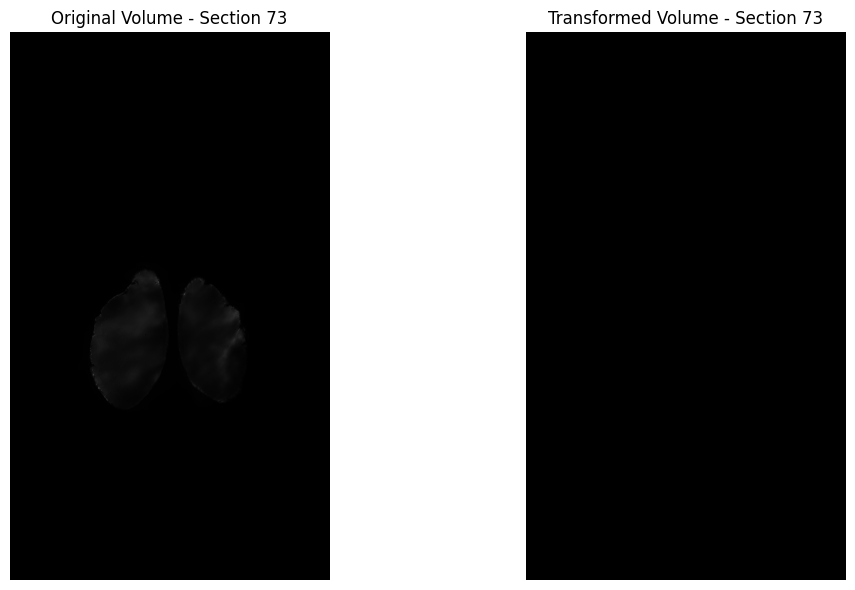

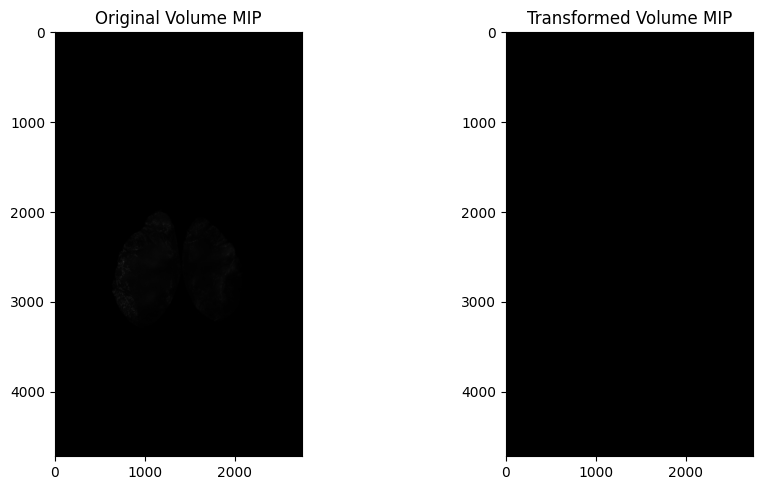

In [179]:
i = 2
row = df_anchoring.loc[i]
original_index = row['original_index']
ox, oy, oz = row['ox'], row['oy'], row['oz']
ux, uy, uz = row['ux'], row['uy'], row['uz']
vx, vy, vz = row['vx'], row['vy'], row['vz']

h = volume.shape[0]
w = volume.shape[1]

xml_affine = generate_affine_matrix_from_anchoring(ox, oy, oz, ux, uy, uz, vx, vy, vz, h, w)

# Compute the inverse of the affine matrix
inverse_affine = np.linalg.inv(xml_affine)

transformed_volume = transform_volume(volume, inverse_affine)

# transformed_volume = transform_volume(volume, xml_affine)

section_index = original_index  # Choose the section index you want to visualize
compare_sections(volume, transformed_volume, section_index)

# Example usage
compare_maximum_projections(volume, transformed_volume)

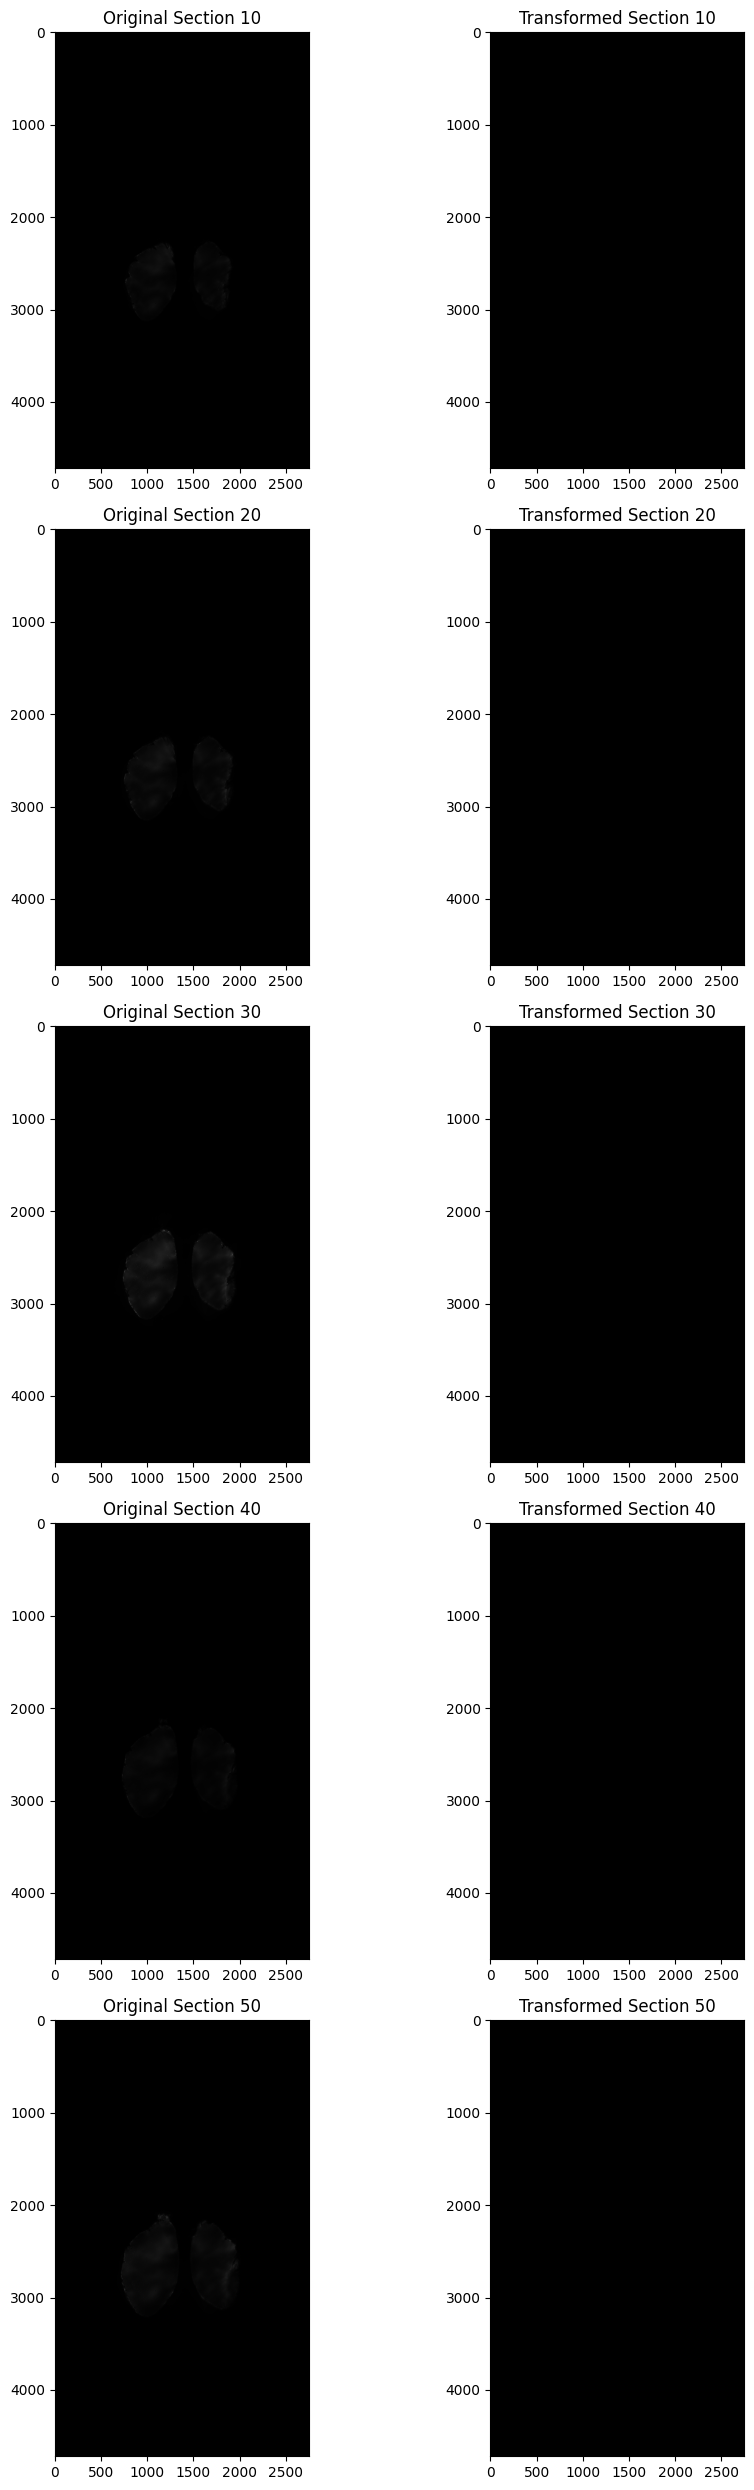

In [138]:
def compare_multiple_sections(original_volume, transformed_volume, section_indices):
    num_sections = len(section_indices)
    fig, axes = plt.subplots(num_sections, 2, figsize=(10, 5 * num_sections))

    for i, index in enumerate(section_indices):
        original_section = original_volume[:, :, index]
        transformed_section = transformed_volume[:, :, index]

        axes[i, 0].imshow(original_section, cmap='gray')
        axes[i, 0].set_title(f'Original Section {index}')

        axes[i, 1].imshow(transformed_section, cmap='gray')
        axes[i, 1].set_title(f'Transformed Section {index}')

    plt.tight_layout()
    plt.show()

# Example usage
section_indices = [10, 20, 30, 40, 50]  # Choose the section indices you want to visualize
compare_multiple_sections(volume, transformed_volume, section_indices)


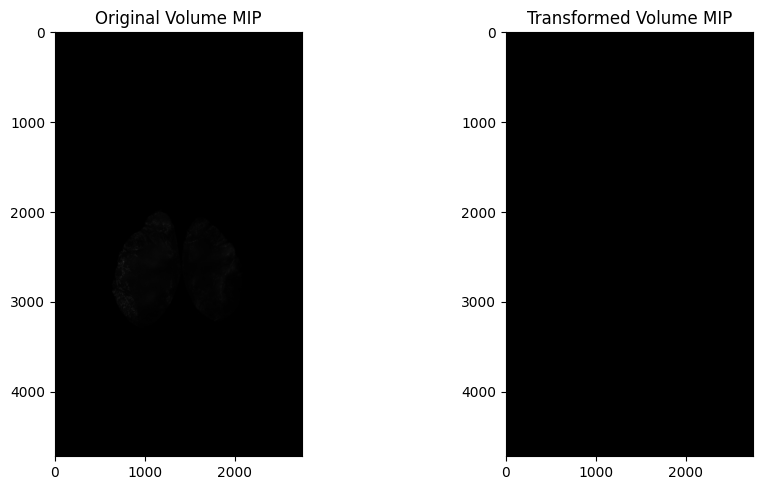

In [139]:
def compare_maximum_projections(original_volume, transformed_volume, axis=2):
    original_mip = np.max(original_volume, axis=axis)
    transformed_mip = np.max(transformed_volume, axis=axis)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_mip, cmap='gray')
    axes[0].set_title('Original Volume MIP')

    axes[1].imshow(transformed_mip, cmap='gray')
    axes[1].set_title('Transformed Volume MIP')

    plt.tight_layout()
    plt.show()

# Example usage
compare_maximum_projections(volume, transformed_volume)


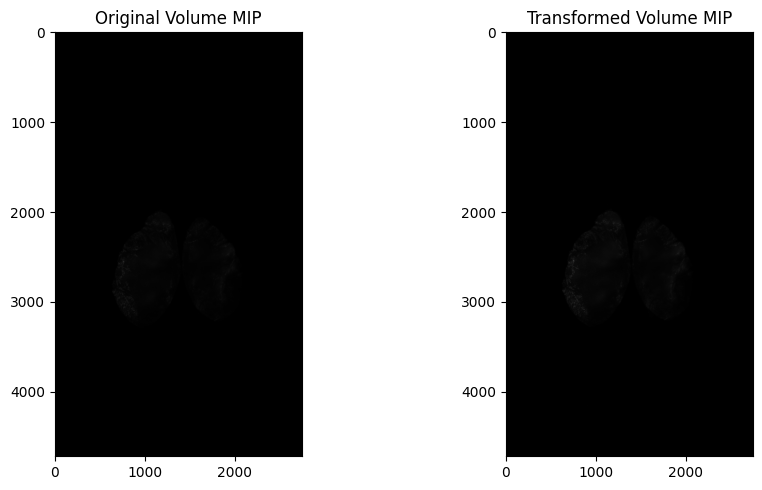

0.0 3.6443049946929484e-06 5.3154698882707055e-09 7.260910148258832e-10


In [142]:
# Generate a simple translation affine matrix
translation_affine = generate_affine_matrix(scale=(1, 1, 1), rotation=(0, 0, 0), translation=(10, 10, 10))

# Apply the translation to the volume
translated_volume = transform_volume(volume, translation_affine)

# Compare the MIPs of the original and translated volumes
compare_maximum_projections(volume, translated_volume)

# Check the statistics of the translated volume
print(np.min(translated_volume), np.max(translated_volume), np.mean(translated_volume), np.median(translated_volume))


In [ ]:
# Testing the other affine transformation function:
# Define simple anchoring parameters
simple_anchoring = {
    "ox": 0,
    "oy": 0,
    "oz": 0,
    "ux": 5,
    "uy": 1,
    "uz": 1,
    "vx": 1,
    "vy": 1,
    "vz": 1
}

# Generate the affine matrix from the simple anchoring parameters
simple_affine = generate_affine_matrix_from_anchoring(**simple_anchoring)

# Apply the simple affine transformation to the volume
simple_transformed_volume = transform_volume(volume, simple_affine)

# Compare the MIPs of the original and transformed volumes
compare_maximum_projections(volume, simple_transformed_volume)

# Check the statistics of the transformed volume
print(np.min(simple_transformed_volume), np.max(simple_transformed_volume), np.mean(simple_transformed_volume), np.median(simple_transformed_volume))


##### A few more tests of other rows

In [170]:
def test_row_affine_transformation(row_index, volume, df_anchoring):
    row = df_anchoring.loc[row_index]
    ox, oy, oz, ux, uy, uz, vx, vy, vz = row[['ox', 'oy', 'oz', 'ux', 'uy', 'uz', 'vx', 'vy', 'vz']]

    xml_affine = generate_affine_matrix_from_anchoring(ox, oy, oz, ux, uy, uz, vx, vy, vz)
    
    # Compute the inverse of the affine matrix
    inverse_affine = np.linalg.inv(xml_affine)
    
    transformed_volume = transform_volume(volume, inverse_affine)

    max_projection_original = np.max(volume, axis=2)
    max_projection_transformed = np.max(transformed_volume, axis=2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(max_projection_original, cmap='gray')
    ax1.set_title("Original Volume")
    ax2.imshow(max_projection_transformed, cmap='gray')
    ax2.set_title("Transformed Volume")
    plt.show()
    
    


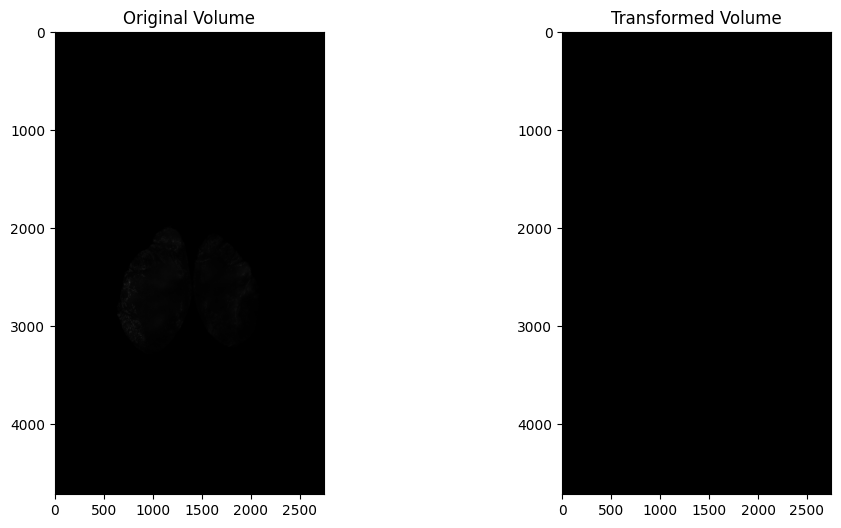

In [171]:
test_row_affine_transformation(0, volume, df_anchoring)  # Test row index 0

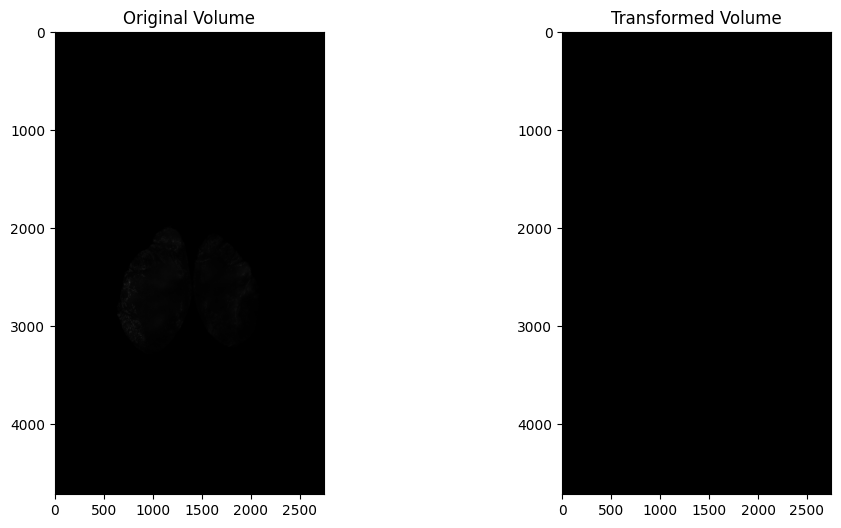

In [172]:
test_row_affine_transformation(1, volume, df_anchoring)  # Test row index 1

# Not working yet. 

### Interpolate the anchoring values for slides where there aren't any. 

In [160]:
# def interpolate_anchoring_data(df_anchoring, total_slices):
#     interpolated_data = [None] * total_slices  # Initialize a list with None values
#     anchor_indices = df_anchoring.index

#     for i in range(total_slices):
#         if i in anchor_indices:
#             interpolated_data[i] = df_anchoring.loc[i].to_dict()
#         else:
#             # Find the closest anchor indices before and after the current index
#             anchors_before = anchor_indices[anchor_indices < i]
#             anchors_after = anchor_indices[anchor_indices > i]

#             if len(anchors_before) == 0:
#                 anchor_before = None
#             else:
#                 anchor_before = anchors_before[-1]

#             if len(anchors_after) == 0:
#                 anchor_after = None
#             else:
#                 anchor_after = anchors_after[0]

#             if anchor_before is None:
#                 anchor_before = anchor_after
#                 weight_before = 1
#                 weight_after = 0
#             elif anchor_after is None:
#                 anchor_after = anchor_before
#                 weight_before = 0
#                 weight_after = 1
#             else:
#                 # Calculate the weights for linear interpolation
#                 weight_before = 1 - (i - anchor_before) / (anchor_after - anchor_before)
#                 weight_after = 1 - weight_before

#             interpolated_row = {}
#             for col in df_anchoring.columns:
#                 if col in ['filename', 'nr', 'original_index']:
#                     interpolated_row[col] = df_slices.loc[i, col]
#                 else:
#                     val_before = df_anchoring.loc[anchor_before, col]
#                     val_after = df_anchoring.loc[anchor_after, col]
#                     interpolated_row[col] = weight_before * val_before + weight_after * val_after

#             interpolated_data[i] = interpolated_row

#     df_interpolated_anchoring = pd.DataFrame(interpolated_data)
#     return df_interpolated_anchoring




In [161]:
# df_anchoring

In [162]:
# total_slices = len(df_slices)
# df_interpolated_anchoring = interpolate_anchoring_data(df_anchoring, total_slices)


In [163]:
# df_interpolated_anchoring